In [38]:
import sys
from pathlib import Path

import numpy as np
import polars as pl
import lightgbm as lgb

work_path = "/home/haselab/Documents/tat/Research/"
sys.path.append(f"{work_path}app/torch_libs/")

from run_manager_new import RunManager, RunsManager, RunViewer

In [39]:
path_total = Path("/home/haselab/Documents/tat/Research/app/sakana_ml/level7_ml/Test_dat2_v2.csv")

df = pl.read_csv(path_total, infer_schema_length=1000)
# display(df)

# x, yともに適用する処理
# nullが10以上ある行をdrop
# df = df.with_columns(pl.Series([row.count(None) for row in df.iter_rows()]).alias("null_count")).filter(pl.col("null_count") < 10).drop("null_count")

# x, yそれぞれに適用する処理
x = df.select(df.columns[:-4])
x = x.select(~ pl.selectors.ends_with("records"))
x = x.select(~ pl.selectors.ends_with("ID"))
x = x.select(~ pl.selectors.ends_with("Scientific name"))
# x = x.select(~ pl.selectors.contains("max size"))
# nullがk行を以下のカラムのみ採用
# x = x.select([col_name for col_name in x.columns if df[col_name].null_count() <=100])
x = x.select([col_name for col_name in x.columns if df[col_name].null_count() <=100 or "associate" in col_name.lower()])

# df = df.select([col_name for col_name in df.columns if df[col_name].null_count() <= 100 or (df.get_column_index(col_name) - df.width) >= -4])


ys = df.select(df.columns[-3:])

# # BlankをNに置き換え
# ys = ys.with_columns(
#     pl.when(pl.all().is_null())
#     .then(pl.lit("N"))
#     .otherwise(pl.all())
#     .name.keep()
# )

# NとYを0, 1に置き換え
ys = ys.with_columns(
    pl.when(pl.all() == "N")
    .then(pl.lit(2))
    .when(pl.all() == "Y")
    .then(pl.lit(1))
    .otherwise(pl.lit(0))
    .name.keep()
)

# display(x)
# display(ys)

# display(x.columns)
# display(ys.columns)



In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss

# テストデータの評価
class Result:
    def __init__(self, val, proba):
        self.val = val
        self.proba = proba
        self.pred = proba.argmax(axis=1)

    def acc(self):
        return accuracy_score(self.val, self.pred)

    def f1(self):
        return f1_score(self.val, self.pred, average="macro") 

    def auc(self):
        return roc_auc_score(self.val, self.pred)
    
    def logloss(self):
        return log_loss(self.val, self.proba)

    def cm(self):
        return confusion_matrix(self.val, self.pred)


    # def acc(self):
    #     return getattr(self, "acc_tmp", self.acc_tmp := accuracy_score(self.val, self.pred))

    # def acc(self):
    #     attrname = "acc_tmp"
    #     try:
    #         return getattr(self, attrname)
    #     except:

    #         score = accuracy_score(self.val, self.pred)

    #         setattr(self, attrname, score)
    #         return getattr(self, attrname)


class Scores:
    def __init__(self):
        self.score_dict = dict()
        
    def __getitem__(self, index):
        return self.score_dict.setdefault(index, [])
    
    def __setitem__(self, key, value):
        self.score_dict[key] = value
        return self
        
    def __attr__(self, attr):
        return self.score_dict.attr

    def __or__(self, other):
        for k, v in other.score_dict.items():
            self.score_dict[k] = v
        return self
    
    def __str__(self):
        for k, v in self.score_dict.items():
            disp_str = ""
            if isinstance(v[0], (int, float)):
                disp_str += f"{k:8} {v[0]}"
        
        return disp_str
    
    def fold(self, val_index_key, cm_key, proba_key):
        s = Scores()
        for k, v in self.score_dict.items():
            if k == val_index_key:
                pass
            elif k == cm_key:
                s[k].append(np.sum(v, axis=0))
            elif k == proba_key:
                num_datas = sum(len(sublist) for sublist in self.score_dict[val_index_key])
                proba = [None for _ in range(num_datas)]
                for val_part, proba_part in zip(self.score_dict[val_index_key], self.score_dict[proba_key]): 
                    for i, idx in enumerate(val_part):
                        proba[idx] = proba_part[i]
                s[k].append(proba)
            else:
                s[k].append(np.mean(v, axis=0))
        return s

    def ave(self):
        s = Scores()
        for k, v in self.score_dict.items():
            s[k].append(np.mean(v, axis=0))
            # if isinstance(v[0], np.ndarray):
            #     s[k].append(np.mean(v, axis=0))
            # else:
            #     s[k].append(sum(v) / len(v))
        return s

                    
            

        

    

In [41]:
import pathlib
import optuna
# Using scikit-learn API
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss

import matplotlib.pyplot as plt
import seaborn as sns


file_name = "db.sqlite3",
file_path = Path(f"sqlite:///{file_name}")
file_path.unlink(missing_ok=True)

params_list = []

for i, y in enumerate(ys):

    def objective(trial):
        params = {
            "boosting_type": "gbdt",
            'objective': 'binary',
            "n_estimators": 100,
            "learning_rate": 0.1,

            "max_depth": trial.suggest_int("max_depth", 1, 7), # 10
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
            "num_leaves": trial.suggest_int("num_leaves", 25, 60), # 31
            "subsample": trial.suggest_float("subsample", 0.4, 1.0), # 1.0 bagging_fracation

            "task": "train",
            'metric':'binary_logloss',
            'seed': 0,
            'verbosity': -1,
        }

        f = Scores()
        for ri in range(5):
            kf = KFold(n_splits=4, shuffle=True, random_state=ri)
            
            s = Scores()
            for fold, (train_indices, val_indices) in enumerate(kf.split(x)):
                x_train, x_val = x[train_indices], x[val_indices]
                y_train, y_val = y[train_indices], y[val_indices]
                
                model = lgb.LGBMClassifier(**params)
                model.fit(x_train, y_train)

                y_proba = model.predict_proba(x_val)

                r = Result(y_val, y_proba)
                s["acc"].append(r.acc())
                s["f1"].append(r.f1())
                s["auc"].append(r.auc())
                s["logloss"].append(r.logloss())
                s["cm"].append(r.cm())
                s["proba"].append(r.proba)
                s["ind"].append(val_indices)
                s["feat_imp"].append(model.feature_importances_)

            f |= s.fold("ind", "cm", "proba")

        a = f.ave()

        # print(a["logloss"][0])
        # print(a["cm"][0])

        return a["logloss"][0]


    study = optuna.create_study(
        storage=file_path,
        study_name=f"Nyaaaaaaaaaaaa{i}",
        direction='minimize',
        load_if_exists=True,
    )
    study.optimize(objective, n_trials=10)

    params = {
        "boosting_type": "gbdt",
        'objective': 'binary',
        "n_estimators": 100,
        "learning_rate": 0.1,

        "task": "train",
        'metric':'binary_logloss',
        'seed': 0,
        'verbosity': -1,
    }
    params |= study.best_params
    params_list.append(params)








AttributeError: 'tuple' object has no attribute 'unlink'


max size0_midPoint            :40.0
Lat0_Top                      :11.5
Habitat0_Top                  :7.75
Lon0_Top                      :7.5
Behavior0_Bottom              :5.25
Behavior0_Average             :4.25
Habitat0_Average              :3.5
Associate0_Bottom             :3.25
DDepth_Top                    :3.0
Lat0_Bottom                   :2.75
NDepth_Bottom                 :2.5
Associate0_Top                :2.5
DDepth_Bottom                 :2.25
Habitat0_Bottom               :2.0
Behavior0_Top                 :0.75
NDepth_Top                    :0.5
DDepth_midPoint               :0.25
Lon0_Bottom                   :0.25
TemperatureT0_Top             :0.25
NDepth_midPoint               :0.0
Salinity0_Bottom              :0.0
Salinity0_Top                 :0.0
Salinity0_Average             :0.0
TemperatureT0_Bottom          :0.0
TemperatureT0_Average         :0.0
Associate0_Average            :0.0
Associate_Floating object     :0.0
Associate_Large pelagics      :0.0

max si

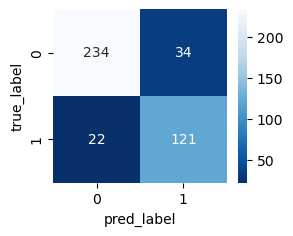

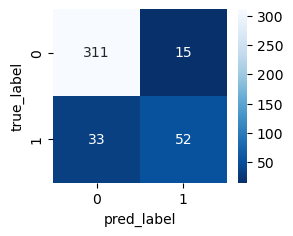

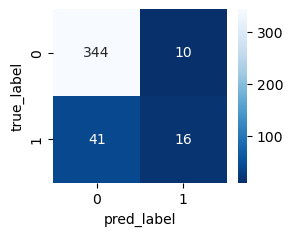

In [ ]:
# Using scikit-learn API
df_pred = df[:-4]
df_probas = None

for y, params in zip(ys, params_list):

    f = Scores()
    for ri in range(5):
        kf = KFold(n_splits=4, shuffle=True, random_state=ri)
        
        s = Scores()
        for fold, (train_indices, val_indices) in enumerate(kf.split(x)):
            x_train, x_val = x[train_indices], x[val_indices]
            y_train, y_val = y[train_indices], y[val_indices]
            
            model = lgb.LGBMClassifier(**params)
            model.fit(x_train, y_train)

            y_proba = model.predict_proba(x_val)

            r = Result(y_val, y_proba)
            s["acc"].append(r.acc())
            s["f1"].append(r.f1())
            s["auc"].append(r.auc())
            s["logloss"].append(r.logloss())
            s["cm"].append(r.cm())
            s["proba"].append(r.proba)
            s["ind"].append(val_indices)
            s["feat_imp"].append(model.feature_importances_)

        f |= s.fold("ind", "cm", "proba")
    a = f.ave()

    se_proba = pl.Series(a["proba"][0][:, 1]).rename(y.name + "_prob")
    if df_probas is None:
        df_probas = se_proba.to_frame()
    else:
        df_probas = df_probas.with_columns(se_proba)

    print(a)

    cf = {c: f for c, f in zip(x.columns, a["feat_imp"][0])}
    cf = {k: v for k, v in sorted(cf.items(), key=lambda item: item[1], reverse=True)}

    for c, f in cf.items():
        print(f"{c:30}:{f}")


    fig, ax = plt.subplots()
    fig.set_figwidth(3)
    fig.set_figheight(2.25)

    ax = sns.heatmap(a["cm"][0], annot=True, cbar=True, square=True, fmt=".0f", cmap="Blues_r", xticklabels=list(range(a["cm"][0].shape[0])), yticklabels=list(range(a["cm"][0].shape[1])))
    ax.set_xlabel("pred_label")
    ax.set_ylabel("true_label")



In [ ]:
df_res = df_probas.with_columns(
    pl.when(pl.all() < 0.5)
    .then(pl.lit("N"))
    .otherwise(pl.lit("Y"))
    .name
    .map(lambda x: x[:-5] + "_pred")
)

df_pred = pl.concat([df, df_res], how="horizontal")
df_pred.write_csv("./prediction.csv")

